In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
from tqdm import tqdm
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Problem: Taylor is WAY OFF for $np>1$...

Hypothesis: need to add second term to the mean as only MEAN is off and variance is fine.
Need to calculate $L''_{ii}$, diagonal of the Hessian

A bit better (for second layer) with it....

In [262]:
# tf._hessian_vector_product -- use for VarDelta regularization

In [263]:
# network configuration
N = [100, 200]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, 0, p]  + [0] * (len(N) - 1)

# prob. of failure at inference
p_inf = 1e-4
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_35 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/step - loss: 109.1019 - categorical_accuracy: 0.7923 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1447 - val_loss: 29.6254 - val_categorical_accuracy: 0.9055 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1062
Epoch 2/10
60000/60000 [==========================

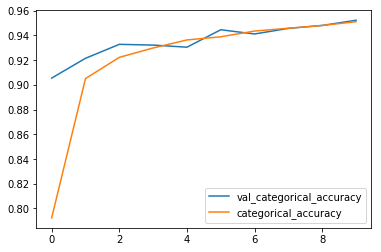

Creating network for 784-dimensional input and 10-dimensional output, with 2 hidden layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_38 (Dense)             (None, 200)               20200     
_________________________________________________________________
Crashes (Lambda)             (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 100)     

In [264]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = 'balanced', reg_coeff = 1e-5, do_print = True,
                                      name = 'experiment_weights', seed = None, batch_size = 100)

In [265]:
truth = exp.y_train

In [165]:
def crashing_loss():
    prediction = exp.predict_crashing(exp.x_train, repetitions = 1)
    prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [166]:
def correct_loss():
    prediction = exp.predict_correct(exp.x_train)
    #prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [167]:
correct = correct_loss()

In [9]:
crashing = [crashing_loss() for _ in tqdm(range(20))]

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


In [10]:
correct * 1000

7.7836008603728715

(array([2., 2., 1., 2., 2., 5., 3., 0., 2., 1.]),
 array([7.79040083, 7.79100509, 7.79160934, 7.7922136 , 7.79281786,
        7.79342211, 7.79402637, 7.79463062, 7.79523488, 7.79583914,
        7.79644339]),
 <a list of 10 Patch objects>)

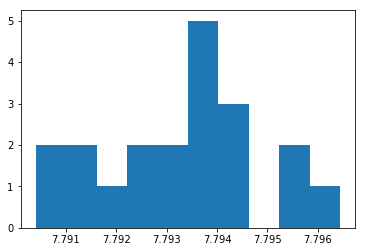

In [11]:
plt.hist(np.array(crashing) * 1000)

In [12]:
# 1. Experimental evaluation -> quite fast, doesn't ruin things much...

In [ ]:
# computing probability delta of bad crash >= alpha

In [181]:
def q_factor(array):
    """ q-balanced factor """
    array = np.abs(array)
    assert np.max(array) > 0, "Cannot compute q-factor for zero array"
        
    return np.min(array) / np.max(array)

q = q_factor(np.linalg.norm(exp.W[1], axis = 1) ** 2)

In [66]:
np.linalg.norm(exp.W[1].flatten(), ord = 1)

1189.2539

In [23]:
p_inf

0.0001

In [177]:
n = N[1]

In [178]:
p_inf * n

0.02

In [179]:
W = np.linalg.norm(exp.W[1], ord = 1, axis = 1)

In [182]:
q

0.38271666

In [40]:
# target probability
delta_0 = 1e-1

In [41]:
a = np.log(2 / delta_0) / (2 * q)

In [42]:
t = (a/n)**0.5

In [43]:
t = (a / n) ** 0.5
alpha = t + p_inf

In [44]:
a, t, alpha

(3.6787729679967103, 0.1918012765337267, 0.19190127653372668)

In [58]:
W = exp.model_correct.layers[1].weights[0]

In [351]:
sess = get_session()

In [ ]:
sess.run(tf.hessians(exp.loss, W), feed_dict = )

In [344]:
p_inf * np.linalg.norm(exp.W[1].flatten(), ord = 1)

0.1181999267578125

In [322]:
t = p_inf * 1000
alpha = (p_inf + t)
print(alpha)

0.10010000000000001


In [312]:
# target probability of big error
delta_target = 1e-5

In [317]:
#t = np.log(1/delta_target) / (2 * n)

In [321]:
n * p_inf

0.01

In [310]:
# Chernoff bound
delta = np.exp(-2*t*n)
delta

2.061153622438558e-09

In [193]:
alpha ** 2

0.10999999999999999

In [194]:
# for CHEBYSHEV
print(np.mean(crashing))
print(np.std(crashing))
a = np.std(crashing) * 3

0.009816558831670864
1.228175672145885e-05


In [195]:
print(np.std(crashing) ** 2 / a ** 2  + delta)

0.24644639434772372


In [154]:
def _get_bound_b5_loss(self, data, outputs, weights = None, add_diag_hess = False):
    """ Exact error up to O(alpha^2) """

    # default value: first hidden layer
    if weights is None:
        weights = self.model_correct.layers[0].output
        self.check_p_layer0()

    def get_graph():
        # resulting gradient w.r.t. first layer output
        grad = []
        grad_sq = []

        # list of layers
        layers = self.model_correct.layers

        # loss tensor
        loss = self.loss

        # w.r.t. first layer output
        if self.check_shape:
            grad += [tf.reduce_sum(tf.multiply(tf.gradients([loss], [weights])[0], weights), axis=1)]
            grad_sq += [tf.reduce_sum(tf.square(tf.multiply(tf.gradients(
                [loss], [weights])[0], weights)), axis=1)]
        else:
            grad += [tf.reduce_sum(tf.multiply(tf.gradients([loss], [weights])[0], weights))]
            grad_sq += [tf.reduce_sum(tf.square(tf.multiply(tf.gradients([loss], [weights])[0], weights)))]

        # compute the result
        p = np.max(p_inference)
            
        if add_diag_hess:
            # squared weights
            Wsq = tf.multiply(weights, weights)

            wshape = weights.shape
            if wshape[0].value is None:
                wshape = wshape[1:]
            
            # diagonal of the hessian. TODO: compute in O(N) instead of O(N^2)
            hess_diag = tf.linalg.tensor_diag_part(tf.reshape(tf.hessians([loss], weights)[0], (*wshape, *wshape)))

            # quadratic term
            S = -0.5 * tf.reduce_sum(tf.multiply(Wsq, hess_diag))
            grad[0] += S
        
        return {'mean': tf.transpose(tf.multiply(-p, grad)), 'std': tf.transpose(tf.sqrt(tf.multiply(p, grad_sq)))}

    return self.run_on_input_output(get_graph(), data, outputs)

In [196]:
W1 = exp.model_correct.layers[1].output

In [197]:
# why is it negative and not equal to the experiment???
theory = _get_bound_b5_loss(exp, exp.x_train, exp.y_train, weights = W1, add_diag_hess = False)

In [200]:
np.mean(theory['mean']), np.mean(theory['std'] ** 2) ** 0.5

(-3.4397557936293496e-05, 0.002791661591393622)

In [99]:
### Trying for a single object...
idx = 10
x = exp.x_train[idx:idx+1]
y = exp.y_train[idx:idx+1]

In [156]:
crashing = exp.predict_crashing(x, repetitions = 1000)#.reshape(1000, 10)
correct = exp.predict_correct(x)

crashing = np.mean(np.square(crashing - y), axis = 2).reshape(-1)

correct = np.mean(np.square(correct - y))

delta = crashing - correct

np.mean(delta), np.std(delta)

In [133]:
# WTF? here crashing error is less than correct...
print(_get_bound_b5_loss(exp, x, y, weights = W1, add_diag_hess = True))
print(_get_bound_b5_loss(exp, x, y, weights = W1, add_diag_hess = False))

{'mean': array([[0.00183269]]), 'std': array([[0.000824]])}
{'mean': array([[1.0128133e-07]]), 'std': array([[0.000824]])}


In [ ]:
exp.get_bound_b3(x)['mean']

In [ ]:
y

In [ ]:
tf.gradients(loss, W0)

In [ ]:
import tensorflow_probability as tfp

In [ ]:
g0 = tf.gradients(loss, W0)[0]

In [ ]:
tf.gradients(loss, W0)

In [ ]:
x = tf.placeholder(tf.float32, shape = (10))

In [ ]:
loss = tf.reduce_sum(tf.square(x))

In [ ]:
g = tf.gradients(loss, x)[0]

In [ ]:
x1 = tf.unstack(x)[0]

In [ ]:
y = tf.square(x)

In [ ]:
tf.gradients(x, x1)

In [ ]:
sess.run(tfp.math.diag_jacobian(g, x), feed_dict = {x: np.random.randn(10, 11)})

In [ ]:
sess.run(tfp.math.diag_jacobian(x, x)[1])

In [ ]:
sess.run(tfp.math.diag_jacobian(g0, W0, sample_shape = [1,1])[1])

In [ ]:
g1 = tf.gradients(g0, W0)

In [ ]:
A = sess.run(g1, feed_dict = {exp.model_correct.input: x, exp.output_tensor: y})[0]

In [ ]:
A

In [67]:
# Tail bound test
# https://en.wikipedia.org/wiki/Binomial_distribution
def kl_num(x, y):
    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

In [84]:
kl_num(0.001,1e-200)

0.45260976348657705

In [86]:
# see https://github.com/tensorflow/tensorflow/issues/25040

import tensorflow as tf
import numpy as np
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow import gradients

def hessian_vector_product(ys, xs, v):
  """Multiply the Hessian of `ys` wrt `xs` by `v`.
  This is an efficient construction that uses a backprop-like approach
  to compute the product between the Hessian and another vector. The
  Hessian is usually too large to be explicitly computed or even
  represented, but this method allows us to at least multiply by it
  for the same big-O cost as backprop.
  Implicit Hessian-vector products are the main practical, scalable way
  of using second derivatives with neural networks. They allow us to
  do things like construct Krylov subspaces and approximate conjugate
  gradient descent.
  Example: if `y` = 1/2 `x`^T A `x`, then `hessian_vector_product(y,
  x, v)` will return an expression that evaluates to the same values
  as (A + A.T) `v`.
  Args:
    ys: A scalar value, or a tensor or list of tensors to be summed to
        yield a scalar.
    xs: A list of tensors that we should construct the Hessian over.
    v: A list of tensors, with the same shapes as xs, that we want to
       multiply by the Hessian.
  Returns:
    A list of tensors (or if the list would be length 1, a single tensor)
    containing the product between the Hessian and `v`.
  Raises:
    ValueError: `xs` and `v` have different length.
  """ 

  # Validate the input
  length = len(xs)
  if len(v) != length:
    raise ValueError("xs and v must have the same length.")

  # First backprop
  grads = gradients(ys, xs)

  # grads = xs

  assert len(grads) == length

  elemwise_products = [
      math_ops.multiply(grad_elem, array_ops.stop_gradient(v_elem))
      for grad_elem, v_elem in zip(grads, v) if grad_elem is not None
  ]

  # Second backprop  
  grads_with_none = gradients(elemwise_products, xs)
  return_grads = [
      grad_elem if grad_elem is not None \
      else tf.zeros_like(x) \
      for x, grad_elem in zip(xs, grads_with_none)]
  
  return return_grads



In [106]:
Ws = exp.model_correct.weights[2:3]

In [105]:
Ws = 

[<tf.Variable 'dense_9/kernel:0' shape=(784, 100) dtype=float32_ref>,
 <tf.Variable 'dense_9/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_10/kernel:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'dense_10/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_11/kernel:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'dense_11/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_12/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_12/bias:0' shape=(10,) dtype=float32_ref>]

In [107]:
sess = get_session()

In [300]:
W = exp.model_correct.layers[1].weights[0]

In [278]:
W

<tf.Variable 'dense_41/kernel:0' shape=(100, 200) dtype=float32_ref>

In [279]:
hvp = hessian_vector_product(exp.loss, [W], [tf.stop_gradient(W)])[0]

In [280]:
wHw = tf.reduce_sum(tf.multiply(tf.abs(hvp), tf.stop_gradient(tf.abs(W))))

In [281]:
feed = {exp.model_correct.input: x, exp.output_tensor: y}

In [188]:
cert_den = sess.run(wHw, feed_dict = feed)

In [173]:
cert_enu = sess.run(tf.reduce_sum(tf.multiply(tf.abs(tf.gradients(exp.loss, W)[0]), tf.abs(W))), feed)

In [174]:
# This is alpha!
cert_enu / cert_den / 10

0.02951110303401947

In [183]:
print(n, q)

200 0.38271666


In [184]:
t = 0.03
print(t, t + p_inf)

0.03 0.0301


In [185]:
np.exp(-n*q*kl_num(t + p_inf, p_inf))

1.8691927046718584e-05

In [159]:
crashing = exp.predict_crashing(x, repetitions = 10000)#.reshape(1000, 10)
correct = exp.predict_correct(x)

crashing = np.mean(np.square(crashing - y), axis = 2).reshape(-1)

correct = np.mean(np.square(correct - y))

delta = crashing - correct

np.mean(delta), np.std(delta)

(1.1894852870413295e-05, 0.00018028125517313703)

In [187]:
p_inf

0.0001

In [214]:
wHwg = tf.gradients(wHw, W)

In [213]:
sess.run(wHwg, feed)[0].shape

(100, 200)

In [284]:
W1 = tf.Variable(tf.zeros_like(W))

array([[-0.21682757,  0.2660623 , -0.13696536, ...,  0.04763535,
        -0.17063715,  0.00432912],
       [-0.3852396 , -0.15810953, -0.01746978, ...,  0.09028391,
        -0.04298741, -0.01647916],
       [ 0.03244729, -0.11132674, -0.1511244 , ..., -0.08711679,
         0.02930702, -0.07788351],
       ...,
       [ 0.00601823,  0.127277  , -0.150358  , ...,  0.07315686,
         0.12544541, -0.0302185 ],
       [ 0.08320521,  0.01221226,  0.00548319, ..., -0.09786451,
        -0.09717263,  0.10645077],
       [-0.32533476, -0.1721567 , -0.06282311, ...,  0.38471898,
        -0.32876042, -0.28661048]], dtype=float32)

In [331]:
hvp = hessian_vector_product(exp.loss, [W], [W1])[0]
wHw = tf.reduce_sum(tf.multiply(tf.abs(hvp), tf.stop_gradient(tf.abs(W1))))

In [332]:
a_op = tf.train.AdamOptimizer(0.1).minimize(-wHw)

In [333]:
sess.run(tf.global_variables_initializer())
sess.run(W1.assign(W))

array([[-0.21682757,  0.2660623 , -0.13696536, ...,  0.04763535,
        -0.17063715,  0.00432912],
       [-0.3852396 , -0.15810953, -0.01746978, ...,  0.09028391,
        -0.04298741, -0.01647916],
       [ 0.03244729, -0.11132674, -0.1511244 , ..., -0.08711679,
         0.02930702, -0.07788351],
       ...,
       [ 0.00601823,  0.127277  , -0.150358  , ...,  0.07315686,
         0.12544541, -0.0302185 ],
       [ 0.08320521,  0.01221226,  0.00548319, ..., -0.09786451,
        -0.09717263,  0.10645077],
       [-0.32533476, -0.1721567 , -0.06282311, ...,  0.38471898,
        -0.32876042, -0.28661048]], dtype=float32)

In [356]:
W

<tf.Variable 'dense_41/kernel:0' shape=(100, 200) dtype=float32_ref>

In [355]:
W + (W - W1) / tf.norm(W - W1) * eps

<tf.Tensor 'sub_4:0' shape=(100, 200) dtype=float32>

In [342]:
nrm = tf.norm(W)

In [353]:
sess.run([wHw / nrm ** 2, a_op], feed)

[1.8591837e-07, None]

In [259]:
np.linalg.norm(exp.W[0])

15.261283

In [ ]:
tf.zeros(W.shape)

In [305]:
hvp

[<tf.Tensor 'gradients_76/dense_41/MatMul_grad/MatMul_1:0' shape=(100, 200) dtype=float32>]

array([[-0.21682757,  0.2660623 , -0.13696536, ...,  0.04763535,
        -0.17063715,  0.00432912],
       [-0.3852396 , -0.15810953, -0.01746978, ...,  0.09028391,
        -0.04298741, -0.01647916],
       [ 0.03244729, -0.11132674, -0.1511244 , ..., -0.08711679,
         0.02930702, -0.07788351],
       ...,
       [ 0.00601823,  0.127277  , -0.150358  , ...,  0.07315686,
         0.12544541, -0.0302185 ],
       [ 0.08320521,  0.01221226,  0.00548319, ..., -0.09786451,
        -0.09717263,  0.10645077],
       [-0.32533476, -0.1721567 , -0.06282311, ...,  0.38471898,
        -0.32876042, -0.28661048]], dtype=float32)